Epoch [1/150] | Train Acc: 63.41% | Test Acc: 50.00% | Loss: 4.5470
Epoch [2/150] | Train Acc: 79.27% | Test Acc: 59.76% | Loss: 2.3485
Epoch [3/150] | Train Acc: 96.34% | Test Acc: 59.76% | Loss: 0.1654
Epoch [4/150] | Train Acc: 96.34% | Test Acc: 50.00% | Loss: 0.1830
Epoch [5/150] | Train Acc: 96.34% | Test Acc: 50.00% | Loss: 0.5480
Epoch [6/150] | Train Acc: 93.90% | Test Acc: 50.00% | Loss: 0.3662
Epoch [7/150] | Train Acc: 100.00% | Test Acc: 52.44% | Loss: 0.0026
Epoch [8/150] | Train Acc: 98.78% | Test Acc: 63.41% | Loss: 0.0510
Epoch [9/150] | Train Acc: 100.00% | Test Acc: 63.41% | Loss: 0.0564
Epoch [10/150] | Train Acc: 100.00% | Test Acc: 64.63% | Loss: 0.0370
Epoch [11/150] | Train Acc: 100.00% | Test Acc: 62.20% | Loss: 0.0882
Epoch [12/150] | Train Acc: 100.00% | Test Acc: 58.54% | Loss: 0.0259
Epoch [13/150] | Train Acc: 100.00% | Test Acc: 57.32% | Loss: 0.0082
Epoch [14/150] | Train Acc: 100.00% | Test Acc: 57.32% | Loss: 0.0235
Epoch [15/150] | Train Acc: 100.00% 

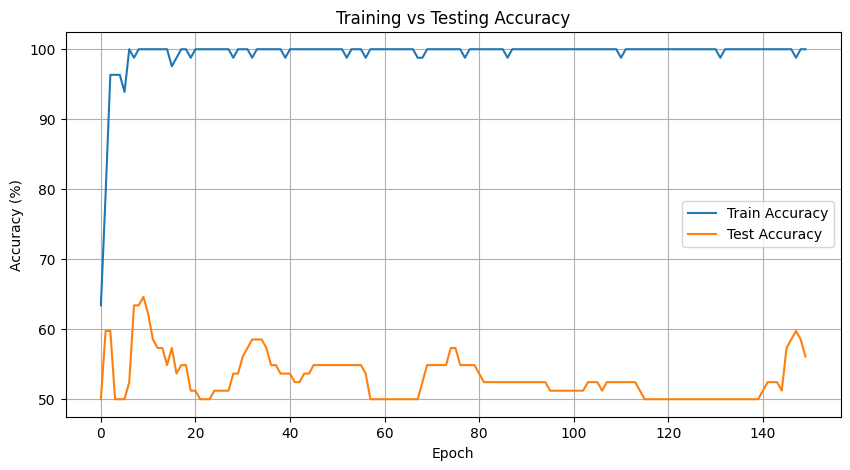

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation (with augmentation)
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.classes)

# ----------------------------
# Simpler CNN Classifier
# ----------------------------
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Dropout(0.25)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 32 * 32, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# ----------------------------
# Training Setup
# ----------------------------
model = CNNClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-8)

num_epochs = 150
train_losses = []
train_accuracies = []
test_accuracies = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100. * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {running_loss:.4f}")

# ----------------------------
# Plot Accuracy and Loss
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)
plt.show()



Epoch [1/150] | Train Acc: 54.40% | Test Acc: 50.00% | Loss: 27.1791
Epoch [2/150] | Train Acc: 65.93% | Test Acc: 50.00% | Loss: 9.0728
Epoch [3/150] | Train Acc: 61.54% | Test Acc: 58.54% | Loss: 3.9149
Epoch [4/150] | Train Acc: 65.93% | Test Acc: 58.54% | Loss: 3.7548
Epoch [5/150] | Train Acc: 67.58% | Test Acc: 54.88% | Loss: 3.4600
Epoch [6/150] | Train Acc: 65.38% | Test Acc: 64.63% | Loss: 3.3893
Epoch [7/150] | Train Acc: 70.33% | Test Acc: 63.41% | Loss: 3.3878
Epoch [8/150] | Train Acc: 70.33% | Test Acc: 56.10% | Loss: 3.2069
Epoch [9/150] | Train Acc: 69.78% | Test Acc: 69.51% | Loss: 3.2249
Epoch [10/150] | Train Acc: 73.08% | Test Acc: 62.20% | Loss: 2.8931
Epoch [11/150] | Train Acc: 67.58% | Test Acc: 52.44% | Loss: 3.1741
Epoch [12/150] | Train Acc: 63.19% | Test Acc: 59.76% | Loss: 3.2655
Epoch [13/150] | Train Acc: 69.23% | Test Acc: 52.44% | Loss: 3.0726
Epoch [14/150] | Train Acc: 69.78% | Test Acc: 50.00% | Loss: 2.9941
Epoch [15/150] | Train Acc: 75.27% | Test 

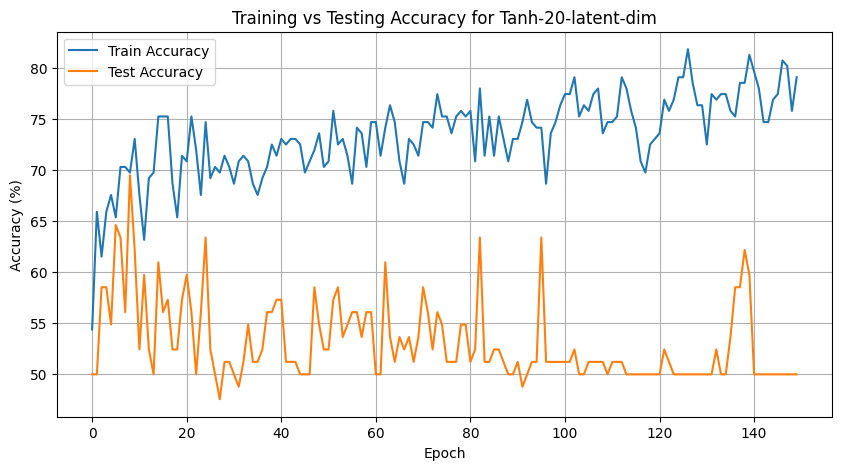

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation (with augmentation)
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

visualize_paramters="Tanh-20-latent-dim"
train_dataset_1 = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)

# Load the second dataset (fake_Data.train)
train_dataset_2 = datasets.ImageFolder(root=f'fake_data_64_by_64/{visualize_paramters}', transform=data_transforms)

# Combine the two datasets
train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])

test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset_1.classes)

# ----------------------------
# Simpler CNN Classifier
# ----------------------------
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Dropout(0.25)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 32 * 32, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# ----------------------------
# Training Setup
# ----------------------------
model = CNNClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-8)

num_epochs = 150
train_losses = []
train_accuracies = []
test_accuracies = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100. * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {running_loss:.4f}")

# ----------------------------
# Plot Accuracy and Loss
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training vs Testing Accuracy for {visualize_paramters}')
plt.legend()
plt.grid(True)
plt.show()



Epoch [1/150] | Train Acc: 51.10% | Test Acc: 50.00% | Loss: 31.3118
Epoch [2/150] | Train Acc: 52.20% | Test Acc: 64.63% | Loss: 9.4186
Epoch [3/150] | Train Acc: 57.14% | Test Acc: 67.07% | Loss: 4.2478
Epoch [4/150] | Train Acc: 58.24% | Test Acc: 62.20% | Loss: 3.9913
Epoch [5/150] | Train Acc: 59.34% | Test Acc: 68.29% | Loss: 3.8954
Epoch [6/150] | Train Acc: 58.79% | Test Acc: 53.66% | Loss: 3.9039
Epoch [7/150] | Train Acc: 65.38% | Test Acc: 56.10% | Loss: 3.7699
Epoch [8/150] | Train Acc: 64.84% | Test Acc: 64.63% | Loss: 3.5918
Epoch [9/150] | Train Acc: 69.23% | Test Acc: 57.32% | Loss: 3.5125
Epoch [10/150] | Train Acc: 70.33% | Test Acc: 56.10% | Loss: 3.4620
Epoch [11/150] | Train Acc: 67.58% | Test Acc: 63.41% | Loss: 3.4541
Epoch [12/150] | Train Acc: 64.29% | Test Acc: 58.54% | Loss: 3.6652
Epoch [13/150] | Train Acc: 69.23% | Test Acc: 52.44% | Loss: 3.3276
Epoch [14/150] | Train Acc: 62.64% | Test Acc: 54.88% | Loss: 3.4925
Epoch [15/150] | Train Acc: 68.13% | Test 

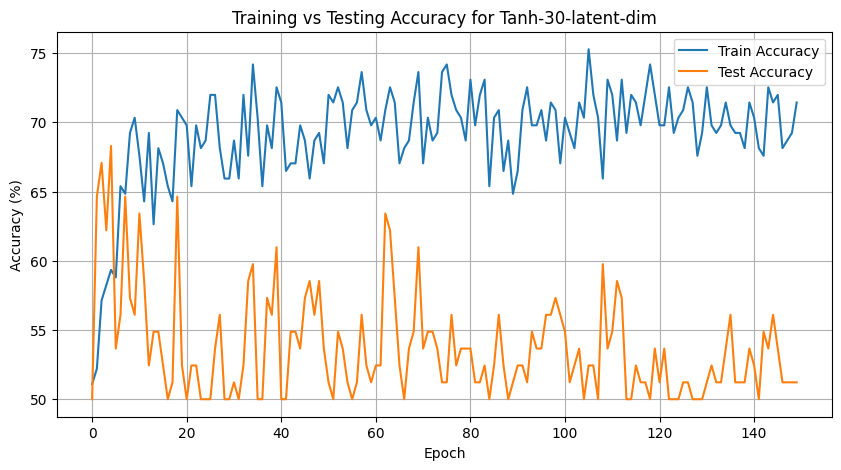

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation (with augmentation)
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

visualize_paramters="Tanh-30-latent-dim"
train_dataset_1 = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)

# Load the second dataset (fake_Data.train)
train_dataset_2 = datasets.ImageFolder(root=f'fake_data_64_by_64/{visualize_paramters}', transform=data_transforms)

# Combine the two datasets
train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])

test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset_1.classes)

# ----------------------------
# Simpler CNN Classifier
# ----------------------------
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Dropout(0.25)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 32 * 32, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# ----------------------------
# Training Setup
# ----------------------------
model = CNNClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-8)

num_epochs = 150
train_losses = []
train_accuracies = []
test_accuracies = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100. * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {running_loss:.4f}")

# ----------------------------
# Plot Accuracy and Loss
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training vs Testing Accuracy for {visualize_paramters}')
plt.legend()
plt.grid(True)
plt.show()



Epoch [1/150] | Train Acc: 51.10% | Test Acc: 50.00% | Loss: 31.7764
Epoch [2/150] | Train Acc: 51.65% | Test Acc: 46.34% | Loss: 5.8389
Epoch [3/150] | Train Acc: 56.04% | Test Acc: 46.34% | Loss: 3.9269
Epoch [4/150] | Train Acc: 57.69% | Test Acc: 47.56% | Loss: 3.8702
Epoch [5/150] | Train Acc: 60.44% | Test Acc: 54.88% | Loss: 3.7735
Epoch [6/150] | Train Acc: 56.59% | Test Acc: 63.41% | Loss: 3.7116
Epoch [7/150] | Train Acc: 64.84% | Test Acc: 54.88% | Loss: 3.4678
Epoch [8/150] | Train Acc: 66.48% | Test Acc: 54.88% | Loss: 3.3066
Epoch [9/150] | Train Acc: 63.74% | Test Acc: 50.00% | Loss: 3.2785
Epoch [10/150] | Train Acc: 63.19% | Test Acc: 47.56% | Loss: 3.3747
Epoch [11/150] | Train Acc: 57.14% | Test Acc: 50.00% | Loss: 3.5851
Epoch [12/150] | Train Acc: 63.19% | Test Acc: 50.00% | Loss: 3.3001
Epoch [13/150] | Train Acc: 61.54% | Test Acc: 50.00% | Loss: 3.3376
Epoch [14/150] | Train Acc: 59.34% | Test Acc: 54.88% | Loss: 3.3053
Epoch [15/150] | Train Acc: 59.89% | Test 

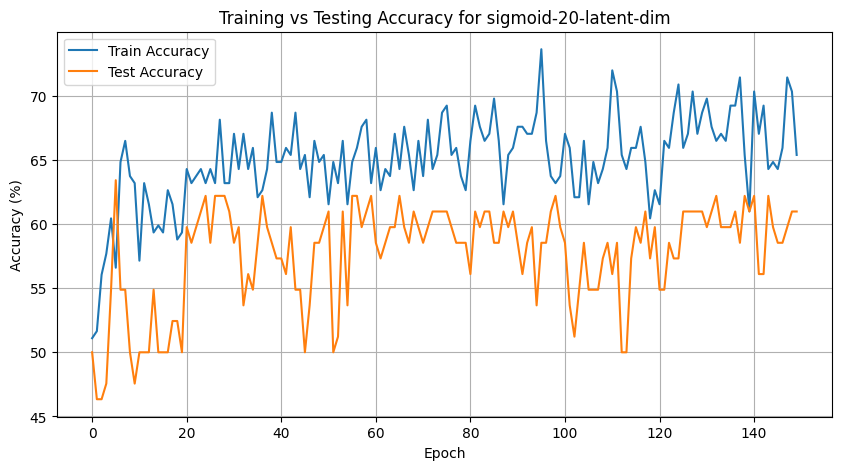

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation (with augmentation)
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

visualize_paramters="sigmoid-20-latent-dim"
train_dataset_1 = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)

# Load the second dataset (fake_Data.train)
train_dataset_2 = datasets.ImageFolder(root=f'fake_data_64_by_64/{visualize_paramters}', transform=data_transforms)

# Combine the two datasets
train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])

test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset_1.classes)

# ----------------------------
# Simpler CNN Classifier
# ----------------------------
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Dropout(0.25)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 32 * 32, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# ----------------------------
# Training Setup
# ----------------------------
model = CNNClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-8)

num_epochs = 150
train_losses = []
train_accuracies = []
test_accuracies = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100. * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {running_loss:.4f}")

# ----------------------------
# Plot Accuracy and Loss
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training vs Testing Accuracy for {visualize_paramters}')
plt.legend()
plt.grid(True)
plt.show()



Epoch [1/150] | Train Acc: 49.45% | Test Acc: 47.56% | Loss: 44.8827
Epoch [2/150] | Train Acc: 62.64% | Test Acc: 50.00% | Loss: 11.6124
Epoch [3/150] | Train Acc: 57.69% | Test Acc: 50.00% | Loss: 3.9281
Epoch [4/150] | Train Acc: 52.75% | Test Acc: 58.54% | Loss: 3.9178
Epoch [5/150] | Train Acc: 54.95% | Test Acc: 54.88% | Loss: 3.5926
Epoch [6/150] | Train Acc: 58.24% | Test Acc: 53.66% | Loss: 3.4755
Epoch [7/150] | Train Acc: 63.74% | Test Acc: 47.56% | Loss: 3.3379
Epoch [8/150] | Train Acc: 60.99% | Test Acc: 50.00% | Loss: 3.2794
Epoch [9/150] | Train Acc: 60.99% | Test Acc: 50.00% | Loss: 3.2185
Epoch [10/150] | Train Acc: 65.38% | Test Acc: 52.44% | Loss: 2.9729
Epoch [11/150] | Train Acc: 60.44% | Test Acc: 46.34% | Loss: 3.6141
Epoch [12/150] | Train Acc: 55.49% | Test Acc: 47.56% | Loss: 3.4754
Epoch [13/150] | Train Acc: 57.14% | Test Acc: 52.44% | Loss: 3.4966
Epoch [14/150] | Train Acc: 62.64% | Test Acc: 52.44% | Loss: 3.1756
Epoch [15/150] | Train Acc: 67.58% | Test

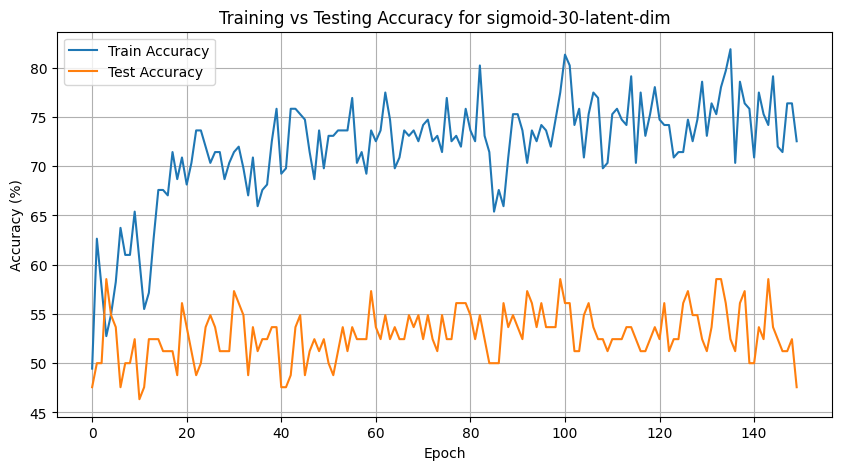

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Data Preparation (with augmentation)
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

visualize_paramters="sigmoid-30-latent-dim"
train_dataset_1 = datasets.ImageFolder(root='dataset/Train', transform=data_transforms)

# Load the second dataset (fake_Data.train)
train_dataset_2 = datasets.ImageFolder(root=f'fake_data_64_by_64/{visualize_paramters}', transform=data_transforms)

# Combine the two datasets
train_dataset = torch.utils.data.ConcatDataset([train_dataset_1, train_dataset_2])

test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset_1.classes)

# ----------------------------
# Simpler CNN Classifier
# ----------------------------
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        
            nn.Dropout(0.25)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 32 * 32, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# ----------------------------
# Training Setup
# ----------------------------
model = CNNClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-8)

num_epochs = 150
train_losses = []
train_accuracies = []
test_accuracies = []

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Evaluation on test set
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()

    test_acc = 100. * correct_test / total_test
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {running_loss:.4f}")

# ----------------------------
# Plot Accuracy and Loss
# ----------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title(f'Training vs Testing Accuracy for {visualize_paramters}')
plt.legend()
plt.grid(True)
plt.show()

